# Notes on window strat

## Windower Class

- Looks like `Windower` objects control what part of a given sequence energy calculations are made for
    - The runtime of energy calcs is not clear right now but guessing it is probably linear-ish for the length of the windowed sequence

In [13]:
seq = 'ATGCCCCAGGGT'
start, stop, min_size = 0, 1, 2
c = 0

while True:
    if start == stop - min_size+1 and stop == len(seq) -1:
        break
    print(seq[start:stop+1])
    c += 1
    if stop < len(seq) - 1:
        stop += 1
    else:
        start += 1
        stop = start + min_size -1

print("Sequence of len {} produced {} structures".format(len(seq), c))

AT
ATG
ATGC
ATGCC
ATGCCC
ATGCCCC
ATGCCCCA
ATGCCCCAG
ATGCCCCAGG
ATGCCCCAGGG
ATGCCCCAGGGT
TG
TGC
TGCC
TGCCC
TGCCCC
TGCCCCA
TGCCCCAG
TGCCCCAGG
TGCCCCAGGG
TGCCCCAGGGT
GC
GCC
GCCC
GCCCC
GCCCCA
GCCCCAG
GCCCCAGG
GCCCCAGGG
GCCCCAGGGT
CC
CCC
CCCC
CCCCA
CCCCAG
CCCCAGG
CCCCAGGG
CCCCAGGGT
CC
CCC
CCCA
CCCAG
CCCAGG
CCCAGGG
CCCAGGGT
CC
CCA
CCAG
CCAGG
CCAGGG
CCAGGGT
CA
CAG
CAGG
CAGGG
CAGGGT
AG
AGG
AGGG
AGGGT
GG
GGG
GGGT
GG
GGT
Sequence of len 12 produced 65 structures


# Energy Calcs

## What is happening to each of the structures produced by the algo above?

- Called in `model.compute_structure` and pushed back onto the `rloop_structures` vector
    - for each rloop structure we then call `compute_residuals` and pass in the `Model` we are using
        - `compute_residuals` computes the residual linking difference and the residual twist and stores both of these in the `structure` instance that was passed in

## Residual linking difference

$(\frac{4C(\pi^{2})}{4C(\pi^{2}) + (K \cdot L)})\alpha + L * A$

Where

- $C$ = tortional stiffness of ssDNA winding. (Could be 3.6 for ds or 1.8 for ss winding)
- $A$ = turns/bp
- $L$ = length of the sequence
- $\alpha$ = linking difference: topological parameter
- $K$ = Hooke's law coefficient: (2200*ideal_gas_constant in kcal/mol*absolute_temp_in_kelvin)/N

Above should actually be a fast calculation though $\theta(1)$. The big time loss is the number of structures that have to be computed for and the base-pairing energy over the each structure

## Base-pairing energy

Two things are computed here in a for loop in the `Rloop_equilibrium_model::compute_structure` method

1. Free Energy
    - Take adjacent bases call `step_forward_bps` which calls `compute_bps_interval` which returns a cached energy value based on the identity of the first and then second base
    - $\theta(1)$
2. Boltzmann Factor
    - Call `compute_boltzman_factor` and pass in the free energy value we just calculated for the last two adjacent bases and constant $T$
    - $\theta(1)$

## Base-pairing energy improvements

It might make more sense to calculate free energy and boltzman while we are generating each struct instead of calculating all structures and then for each structure do the energy calc again. We end up repeating a **TON** of calculations it seems like

### Example

In [2]:
# create class to represent rloop structures (windows)
class Struct:
    seq = None
    def __init__(self, start, stop):
        self.start = start
        self.stop = stop
        self.boltz = 0
        self.free_energy = 0
        
    @property
    def sequence(self):
        return self.seq[self.start:self.stop]

In [3]:
# set class variable seq to the seq we want to use for calcs
Struct.seq = 'ATGCCCCAGGGT'

In [4]:
T = 0.64  # stand in for T constant
calc_free = lambda a, b: ord(a) + ord(b)  # not actual calc just take ascii values for now as stand in
calc_boltz = lambda e: e + T

### Dynamic programming approach

If we are at the same start point and just building the sequence out we (I think) don't need to recalculate all the free energy calcs done on the preceding bases, just the new base (n) along with the n - 1 base.

In [5]:
def EH_structs():
    import time
    start, stop, min_size = 0, 1, 2

    structures = []
    cur_boltz, cur_energy = 0, 0
    s = time.time()
    while True:
        if start == stop - min_size+1 and stop == len(Struct.seq) -1:
            break
        if stop < len(Struct.seq) - 1:
            new_struct = Struct(start, stop+1)
            cur_energy += calc_free(Struct.seq[new_struct.stop -2], Struct.seq[new_struct.stop-1])
            cur_boltz += calc_boltz(cur_energy)
            new_struct.boltz = cur_boltz
            new_struct.free_energy = cur_energy
            structures.append(new_struct)

            stop += 1

        else:
            start += 1
            stop = start + min_size - 1

            cur_boltz = 0
            cur_energy = 0  # reset as we have moved to new start point
    total_time = time.time() - s
    print("Total Time: {} seconds".format(time.time() - s))
    print("Free Energy | Boltzman | Seq")
    #for s in structures:
    #    print(s.free_energy, round(s.boltz, 2), Struct.seq[s.start:s.stop])
    return total_time

### Same thing as above but with current method

In [6]:
def OG_structs():
    import time
    start, stop, min_size = 0, 1, 2

    structures = []
    s = time.time()
    while True:
        if start == stop - min_size+1 and stop == len(Struct.seq) -1:
            break
        if stop < len(Struct.seq) - 1:
            new_struct = Struct(start, stop+1)

            for i in range(len(new_struct.sequence)-1):
                a, b = new_struct.seq[i], new_struct.seq[i+1]
                new_struct.free_energy += calc_free(a, b)
            new_struct.boltz += calc_boltz(new_struct.free_energy)

            structures.append(new_struct)

            stop += 1

        else:
            start += 1
            stop = start + min_size - 1
    total_time = time.time() - s

    print("Total Time: {} seconds".format(time.time() - s))
    print("Free Energy | Boltzman | Seq")
    #for s in structures:
    #    print(s.free_energy, round(s.boltz, 2), Struct.seq[s.start:s.stop])
    return total_time

In [11]:
EH_time = []
OG_time = []
l = []
Struct.seq = 'ATGCCCCAGGGT'
for i in range(0, 7):
    Struct.seq = Struct.seq * 2
    l.append(len(Struct.seq))
    print('Current length:', l[-1])
    EH_time.append(EH_structs())
    OG_time.append(OG_structs())

Current length: 24
Total Time: 0.0006544589996337891 seconds
Free Energy | Boltzman | Seq
Total Time: 0.0015773773193359375 seconds
Free Energy | Boltzman | Seq
Current length: 48
Total Time: 0.0027348995208740234 seconds
Free Energy | Boltzman | Seq
Total Time: 0.012103557586669922 seconds
Free Energy | Boltzman | Seq
Current length: 96
Total Time: 0.007555484771728516 seconds
Free Energy | Boltzman | Seq
Total Time: 0.046959638595581055 seconds
Free Energy | Boltzman | Seq
Current length: 192
Total Time: 0.016002178192138672 seconds
Free Energy | Boltzman | Seq
Total Time: 0.2863423824310303 seconds
Free Energy | Boltzman | Seq
Current length: 384
Total Time: 0.10921955108642578 seconds
Free Energy | Boltzman | Seq
Total Time: 2.176204204559326 seconds
Free Energy | Boltzman | Seq
Current length: 768
Total Time: 0.39378976821899414 seconds
Free Energy | Boltzman | Seq
Total Time: 17.390355348587036 seconds
Free Energy | Boltzman | Seq
Current length: 1536
Total Time: 1.43608331680297

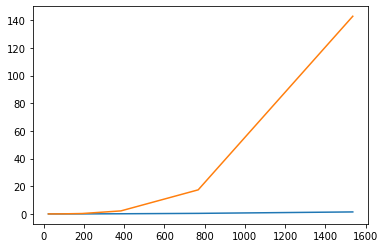

In [12]:
import matplotlib.pyplot as plt
plt.plot(l, EH_time)
plt.plot(l, OG_time)
plt.show()